In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
# преобразование строки с дефектами

def process_defects(defect_str):
    '''
    преобразовывает строку с дефектами в список дефектов
    возвращает список дефектов
    '''
    defect_str = str(defect_str)

    # Обрпабатываем вложенные скобки
    result = []
    buffer = []
    open_parentheses = 0

    for char in defect_str:
        if char == '(':
            if open_parentheses > 0:
                buffer.append(char)
            open_parentheses += 1
            if open_parentheses == 1:
                buffer.append('(')  # Добавляем первую скобку
        elif char == ')':
            open_parentheses -= 1
            if open_parentheses > 0:
                buffer.append(char)
            elif open_parentheses == 0:
                buffer.append(')')
                result.append(''.join(buffer).strip())
                buffer = []
        elif char == ',' and open_parentheses == 0:
            if buffer:
                result.append(''.join(buffer).strip())
                buffer = []
        else:
            buffer.append(char)

    if buffer:
        result.append(''.join(buffer).strip())

    return result


def extract_cycles_count(defect_list):
    '''
    переносит количество включений в отдельный столбец
    возвращает список дефектов без количества включений, количество включений в отдельном столбце
    '''
    if not isinstance(defect_list, list):
        return pd.Series([None, defect_list])

    cycle_count = None
    cleaned_defects = []

    for d in defect_list:
        d_clean = d.strip()

        # Если элемент начинается с "88" (учтём, что могут быть варианты "88", "88-XX", и т.п.)
        if d_clean.startswith("88"):
            match = re.search(r'\((\d+)\+?\)', d_clean)
            if match:
                cycle_count = int(match.group(1))
                # Не добавляем этот элемент в итоговый список дефектов
                continue

        cleaned_defects.append(d)

    return pd.Series([cycle_count, cleaned_defects])


def remove_99_defects(defects):
    '''
    удаляет дефекты с кодом 99-ХХ
    возвращает список без этих дефектов
    '''
    filtered = []
    for d in defects:
        # Если элемент начинается с "99" (с вариантами "99", "99-XX" и т.д.),
        # игнорируем его
        if d.strip().startswith("99"):
            continue
        filtered.append(d)

    return filtered if filtered else None


# только для обработки исторических данных

def extract_cycle_counts_from_list(defects):
    '''
    обрабатывает количество включений, которое внесено неверно
    возвращает количество включений в отдельном столбце
    '''
    if not isinstance(defects, list):
        return pd.Series([None, defects])

    cycle_count = None
    pattern = r'^\((\d+)\+?\)$'

    if defects and re.match(pattern, defects[0]):
        m = re.match(pattern, defects[0])
        if m:
            cycle_count = int(m.group(1))
        defects = defects[1:]

    return pd.Series([cycle_count, defects])


def remove_noncode_comments(defect_list):
    '''
    удаляет неверно внесенные комментарии
    возвращает список без комментариев
    '''
    # Если defect_list — это None, возвращаем его без изменений
    if defect_list is None:
        return defect_list

    # Регулярное выражение для поиска дефектов в формате XX-XX и комментариев в скобках
    valid_defect_pattern = r'^\d{2}-\d{2}(\s*\(.*\))?$'

    # Фильтруем дефекты, оставляя только те, которые соответствуют формату XX-XX (с комментариями в скобках)
    cleaned_list = [defect.strip() for defect in defect_list
                    if pd.notna(defect) and re.match(valid_defect_pattern, defect.strip())]

    return cleaned_list


In [3]:
df = pd.read_excel("masked_data.xlsx")
df = df.dropna(subset=['specification'])
df = df.dropna(subset=['defects'])

df['defects'] = df['defects'].astype(str)
df['specification'] = df['specification'].str.split(',') # преобразуем таргет в список
df['specification'] = df['specification'].apply(lambda lst: [x.strip() for x in lst] if isinstance(lst, list) else []) # удалим пробелы



In [4]:
parts_df = pd.read_excel("parts_descr.xlsx")

In [5]:
parts_df['Unnamed: 2'].unique()

array(['BF-P180', 'BF-1T150', 'BF-1TQ170', 'BF-Q170', 'BF-1TH190',
       'BF-1TH191', 'BF-P190', 'CF-H180AL', 'CF-H180AI', 'BF-1TQ180',
       'BF-P150', 'BF-Q190', 'BF-XP190', 'BF-H190', 'CF-H170I',
       'CF-H170L', 'CF-H190I', 'CF-H190L', 'CF-HQ190I', 'CF-HQ190L',
       'CF-H185I', 'CF-H185L', 'CF-Q150I', 'CF-Q150L', 'CF-Q180AI',
       'CF-Q180AL', 'GIF-H170', 'GIF-H162', 'GIF-H163', 'GIF-H164',
       'GIF-H165', 'GIF-H166', 'GIF-H167', 'GIF-H168', 'GIF-H169',
       'GIF-H180', 'GIF-1TH190', 'GIF-H185', 'GIF-HQ190', 'GIF-H180J',
       'GIF-Q150', 'GIF-N180', 'GIF-XP190N', 'GIF-Q180', 'GIF-XP150N',
       'GIF-XP170N', 'GIF-XP180N'], dtype=object)

In [6]:
#удаляем все неактуальное, из моделей оставляем только те, для которых проведена разметка
df = df[~df['type'].isin(['Electronics', 'CDS', 'Industrial', '08_Выдано', 'SP Rigid', '-'])]
df = df[~df['rep_group'].isin(['Z', 'nan', 'X', 'E'])]
df = df[df['model'].isin(['BF-P180', 'BF-1T150', 'BF-1TQ170', 'BF-Q170', 'BF-1TH190',
       'BF-1TH191', 'BF-P190', 'CF-H180AL', 'CF-H180AI', 'BF-1TQ180',
       'BF-P150', 'BF-Q190', 'BF-XP190', 'BF-H190', 'CF-H170I',
       'CF-H170L', 'CF-H190I', 'CF-H190L', 'CF-HQ190I', 'CF-HQ190L',
       'CF-H185I', 'CF-H185L', 'CF-Q150I', 'CF-Q150L', 'CF-Q180AI',
       'CF-Q180AL', 'GIF-H170', 'GIF-H162', 'GIF-H163', 'GIF-H164',
       'GIF-H165', 'GIF-H166', 'GIF-H167', 'GIF-H168', 'GIF-H169',
       'GIF-H180', 'GIF-1TH190', 'GIF-H185', 'GIF-HQ190', 'GIF-H180J',
       'GIF-Q150', 'GIF-N180', 'GIF-XP190N', 'GIF-Q180', 'GIF-XP150N',
       'GIF-XP170N', 'GIF-XP180N'])]
df = df[~df['out_serv'].isin(['Да'])]



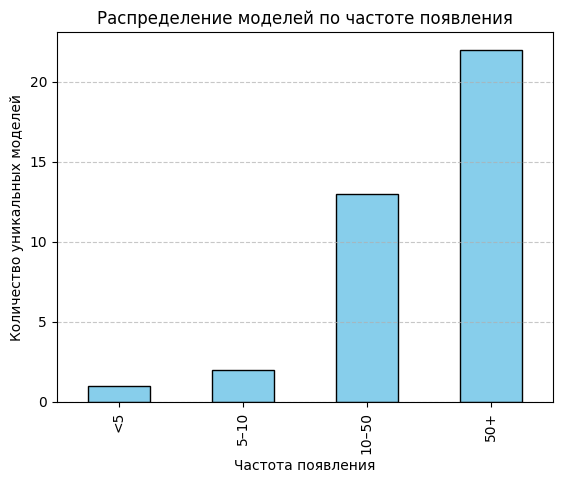

In [7]:
import matplotlib.pyplot as plt

model_counts = df['model'].value_counts()

# Категоризация по частоте
bins = [0, 5, 10, 50, float('inf')]
labels = ['<5', '5–10', '10–50', '50+']
frequency_groups = pd.cut(model_counts, bins=bins, labels=labels, right=False)

# Подсчет количества моделей в каждой группе
group_counts = frequency_groups.value_counts().sort_index()

# Построение гистограммы
group_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Распределение моделей по частоте появления')
plt.xlabel('Частота появления')
plt.ylabel('Количество уникальных моделей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [8]:
df.columns

Index(['repair_num', 'rep_oblect_num', 'model', 'type', 'client', 'user',
       'defects', 'specification', 'rep_group', 'cost ', 'status', 'rep_type',
       'out_serv', 'Дата выдачи'],
      dtype='object')

In [9]:
columns = ['repair_num', 'rep_oblect_num', 'model', 'type', 'client', 'user',
       'defects', 'rep_type']
print('Уникальных значений в каждом столбце:')
for column in columns:
    unique_count = df[column].nunique()
    print(f'{column}: {unique_count}')

Уникальных значений в каждом столбце:
repair_num: 6535
rep_oblect_num: 3866
model: 38
type: 2
client: 385
user: 881
defects: 6455
rep_type: 9


In [10]:
# преобразование дефектов

df['defects'] = df['defects'].apply(process_defects)
df[['cycle_counts', 'defects']] = df['defects'].apply(extract_cycles_count)
df['defects'] = df['defects'].apply(remove_99_defects)
df[['cycle_counts', 'defects']] = df.apply(lambda row: extract_cycle_counts_from_list(row['defects']) if pd.isna(row['cycle_counts']) else pd.Series([row['cycle_counts'], row['defects']]), axis=1)
df['defects'] = df['defects'].apply(remove_noncode_comments)

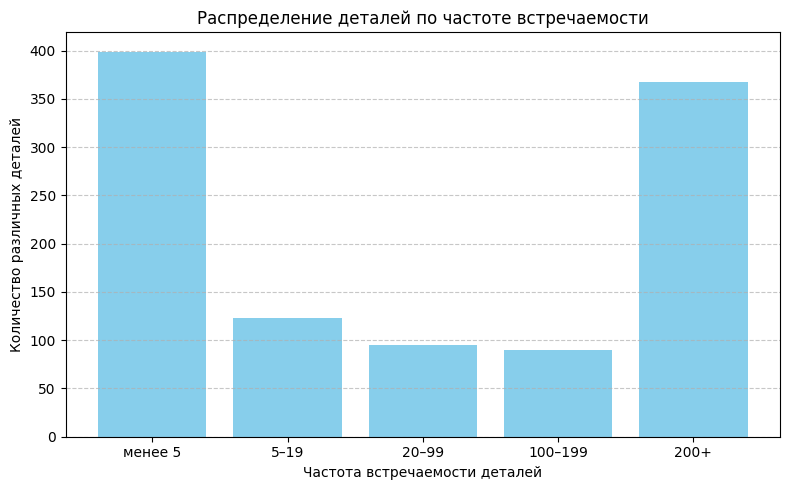

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Группировка по диапазонам
binned_counts = {
    'менее 5': 0,
    '5–19': 0,
    '20–99': 0,
    '100–199': 0,
    '200+': 0
}

# 1. Подсчёт количества встречаемости каждого кода номенклатуры
# Расплющим списки кодов номенклатур в один
all_parts = [part for sublist in df['specification'] for part in sublist]

# Получаем словарь вида: запчасть -> количество вхождений
defect_counts = Counter(all_parts)

# 2. Создаём распределение по количеству вхождений:
# сколько дефектов встречаются N раз
frequency_distribution = Counter(defect_counts.values())

distribution_dict = dict(frequency_distribution)

for freq, num_defects in frequency_distribution.items():
    if freq < 5:
        binned_counts['менее 5'] += num_defects
    elif 10 <= freq < 20:
        binned_counts['5–19'] += num_defects
    elif 50 <= freq < 100:
        binned_counts['20–99'] += num_defects
    elif 100 <= freq < 200:
        binned_counts['100–199'] += num_defects
    else:
        binned_counts['200+'] += num_defects

# Построение графика
plt.figure(figsize=(8, 5))
plt.bar(binned_counts.keys(), binned_counts.values(), color='skyblue')
plt.xlabel("Частота встречаемости деталей")
plt.ylabel("Количество различных деталей")
plt.title("Распределение деталей по частоте встречаемости")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
discontinued_parts = {"RU282800": "RV412900", "GL901500": "RV690300", "GL901800": "RV690200", "GR477300": "RU037900",
                    "RL681900": "RL733400", "RU038000": "RL257300", "GJ652800": "GN025300", "GJ650700": "GN025200",
                    "GR474800": "GE609800", "GJ808300": "RU057900", "GJ916300": "RU043800", "RU695700": "RL001300",
                    "GE385500": "RU031300", "GL890000": "RU039400", "GL715100": "RU071900", "GJ658400": "GN195700",
                    "GN016400": "RU130900", "GN016500": "RU129100", "GJ525600": "GL719700", "GN195600": "GJ660800",
                    "GN701900": "RU132600", "GJ667500": "RU057500", "RC041000": "RC073700", "GN016600": "RU133000", "GR046400": "GR126000",
                    "GJ676000": "GJ925500"}

df['specification'] = df['specification'].apply(
    lambda parts_list: [discontinued_parts.get(code, code) for code in parts_list]
)


In [13]:
parts_df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,DL267000,ФЕРРИТОВОЕ КОЛЬЦО,BF-P180,85
1,DL267000,ФЕРРИТОВОЕ КОЛЬЦО,BF-1T150,85
2,DW724300,ПЛАТА КНОПОК,BF-P180,83
3,DW724300,NaN,BF-1T150,83
4,DW746800,ПЛАТА ПЗС,BF-P180,82
...,...,...,...,...
3125,RU222900,ПЛАТА СОЕДИНЕНИЯ КНОПОК,GIF-XP180N,128
3126,RU591300,ВОЛОКНО ПОДСВЕТКИ,GIF-XP180N,120
3127,RU694900,S-ЦИЛИНДР,GIF-XP180N,125
3128,ZB809100,КОЛПАЧОК ПОДСВЕТКИ ВНЕШНИЙ,GIF-XP180N,88


In [14]:
parts_df['Unnamed: 3'] = parts_df['Unnamed: 3'].astype(str)
parts_df['Unnamed: 0'] = parts_df['Unnamed: 0'].astype(str)
parts_df['Unnamed: 2'] = parts_df['Unnamed: 2'].astype(str)

Заменим коды деталей на метки

In [15]:
from collections import defaultdict

# код номенклатуры → метка
codes_to_labels = dict(
    zip(
        parts_df['Unnamed: 0'],
        parts_df['Unnamed: 3'],
    )
)

def map_codes_to_labels(code_list):
    return [codes_to_labels[code] for code in code_list if code in codes_to_labels]

df['specification_labels'] = df['specification'].apply(map_codes_to_labels)
df = df[df['specification'].str.len() > 0].reset_index(drop=True)

# (метка, модель) → код номенклатуры
label_model_to_codes = defaultdict(list)
for _, row in parts_df.iterrows():
    label = row['Unnamed: 3']
    model = row['Unnamed: 2']
    code = row['Unnamed: 0']
    label_model_to_codes[(label, model)].append(code)


In [16]:
df

,repair_num,rep_oblect_num,model,type,client,user,defects,specification,rep_group,cost,status,rep_type,out_serv,Дата выдачи,cycle_counts,specification_labels
0,17-00735,34603,GIF-Q150,GI Flex,003130,002523,"[00-23, 01-00, 02-01, 02-12, 02-14, 03-00, 04-...","[GE286900, GJ552700, GL868600, GL868900, GL870...",C,203542.74,08_Выдано,Платный,Нет,NaN,NaN,"[6, 43, 47, 90, 2, 82, 84, 161, 44, 1, 57, 5, ..."
1,17-00890,25963,GIF-Q180,GI Flex,001560,002618,"[00-01, 01-00, 04-07, 08-06, 11-10, 87-02, 98-...","[GE284400, GE303400, GH000900, GH000900, GH000...",C,186458.90,08_Выдано,Платный,Нет,NaN,1871.0,"[6, 43, 37, 89, 90, 2, 82, 84, 141, 148, 44, 1..."
2,17-01533,16905,GIF-Q150,GI Flex,001560,001560,"[00-03, 01-14 (износ матрицы), 02-26, 03-00, 0...","[027710, 027711, GE286900, GH207500, GJ552700,...",C,278279.52,08_Выдано,Платный,Нет,NaN,NaN,"[6, 81, 43, 127, 159, 47, 90, 2, 84, 86, 80, 1..."
3,17-01534,18797,GIF-Q150,GI Flex,001560,001335,"[02-01 (незначительный), 02-02 (значительные/ ...","[DW724300, GE286900, GJ525500, GJ552700, GL719...",B,358291.88,08_Выдано,Платный,Нет,NaN,NaN,"[84, 6, 139, 43, 142, 90, 120, 2, 4, 84, 86, 8..."
4,17-01535,6121,GIF-Q150,GI Flex,001560,001560,"[00-09 (переборка и замена ручек не помогает),...","[DW724300, GE286900, GJ552700, GL868900, GL870...",C,239432.01,08_Выдано,Платный,Нет,NaN,55.0,"[84, 6, 43, 90, 65, 2, 82, 44, 1, 5, 5, 121, 7]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,24-04845,80528,GIF-H170,GI Flex,013886,000868,"[00-03, 01-00, 02-03, 03-03, 04-02, 05-03, 08-...","[GE884500, GR188900, GR428100, GR428100, GR428...",C,485604.42,17_Ждет_ремонта,Платный,Нет,NaN,979.0,"[1, 44, 5, 5, 42, 6, 86, 121, 128, 43, 2, 90, ..."
6530,24-04857,6091,GIF-Q180,GI Flex,005582,001190,"[00-09, 00-23 (доставлен со срезанной А-резино...","[GE284400, GE303400, GJ552700, GJ678300, GL720...",B,556153.71,17_Ждет_ремонта,Платный,Нет,NaN,4095.0,"[6, 43, 37, 129, 90, 2, 4, 65, 86, 82, 84, 44,..."
6531,24-04867,56523,CF-H190L,GI Flex,002438,002497,"[00-12 (1), 01-00, 02-02, 02-03, 03-03, 05-06,...","[GE922100, GE922200, GR639300, GS244900, GS244...",F,90214.65,08_Выдано,КЖЦ,Нет,NaN,856.0,"[6, 1, 44, 5, 5, 158, 43]"
6532,24-04869,78058,CF-HQ190L,GI Flex,005428,005428,"[00-01, 01-00 (dual focus - ok), 02-03, 02-07,...","[GR458000, GR517400, GR517400, GR517400, GR517...",B,459472.35,17_Ждет_ремонта,Платный,Нет,NaN,849.0,"[41, 44, 5, 5, 1, 6, 112, 20, 90, 2, 4, 43]"


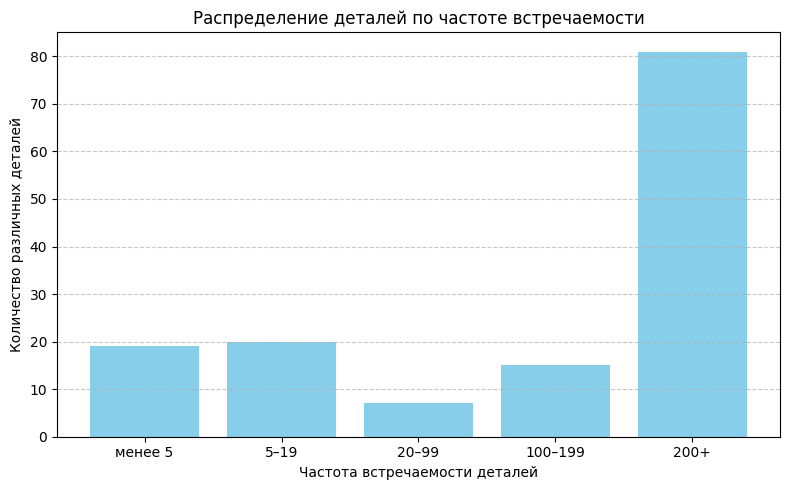

In [17]:
binned_counts = {
    'менее 5': 0,
    '5–19': 0,
    '20–99': 0,
    '100–199': 0,
    '200+': 0
}

# 1. Подсчёт количества встречаемости каждого кода номенклатуры
# Расплющим списки кодов номенклатур в один
all_parts_1 = [part for sublist in df['specification_labels'] for part in sublist]

# Получаем словарь вида: запчасть -> количество вхождений
defect_counts = Counter(all_parts_1)

# 2. Создаём распределение по количеству вхождений:
# сколько дефектов встречаются N раз
frequency_distribution = Counter(defect_counts.values())

distribution_dict = dict(frequency_distribution)

for freq, num_defects in frequency_distribution.items():
    if freq < 5:
        binned_counts['менее 5'] += num_defects
    elif 10 <= freq < 20:
        binned_counts['5–19'] += num_defects
    elif 50 <= freq < 100:
        binned_counts['20–99'] += num_defects
    elif 100 <= freq < 200:
        binned_counts['100–199'] += num_defects
    else:
        binned_counts['200+'] += num_defects

# Построение графика
plt.figure(figsize=(8, 5))
plt.bar(binned_counts.keys(), binned_counts.values(), color='skyblue')
plt.xlabel("Частота встречаемости деталей")
plt.ylabel("Количество различных деталей")
plt.title("Распределение деталей по частоте встречаемости")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
# Получаем список запчастей, которые встречаются менее 5 раз
rare_parts = [part for part, count in defect_counts.items() if count < 5]

# Выводим (например, первые 10 для проверки)
print("Запчасти, встречающиеся менее 5 раз (всего: {}):".format(len(rare_parts)))
print(rare_parts)

Запчасти, встречающиеся менее 5 раз (всего: 19):
['68', '97', '96', '98', '76', '136', '87', '64', '58', '73', '71', '75', '74', '53', '134', '131', '105', '106', '145']


Все эти запчасти являются ибо винтами, либо уплотнительными кольцами, поэтому удалим их

In [19]:
df['specification_labels'] = df['specification_labels'].apply(
    lambda parts: [p for p in parts if p not in rare_parts]
)

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.3 MB/s eta 0:00:00


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import display, IFrame
import matplotlib.pyplot as plt
from pyvis.network import Network
import tempfile
import os
from IPython.display import HTML

# Пример: каждая строка в df['specification_labels'] — список меток, например: ['L001', 'L002']

# 1. Multi-hot представление по spare_labels
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['specification_labels'])  # строки — примеры, колонки — метки
X_T = X.T  # (n_labels, n_samples)
labels = mlb.classes_

# 2. Строим модель ближайших соседей между метками
knn = NearestNeighbors(n_neighbors=10, metric='cosine')  # 6, чтобы исключить саму себя
knn.fit(X_T)
distances, indices = knn.kneighbors(X_T)

# 3. Создание интерактивного графа
net = Network(height="800px", width="100%", notebook=True, cdn_resources='in_line')
net.force_atlas_2based()

for lbl in labels:
    net.add_node(lbl, label=lbl, title=lbl)

for idx, lbl in enumerate(labels):
    for neigh_idx, dist in zip(indices[idx], distances[idx]):
        if lbl == labels[neigh_idx]:
            continue
        similarity = 1 - dist
        net.add_edge(lbl, labels[neigh_idx], value=similarity)

html_path = "/content/spare_labels_graph.html"
net.save_graph(html_path)

with open(html_path, 'r', encoding='utf-8') as f:
    html = f.read()

display(HTML(html))

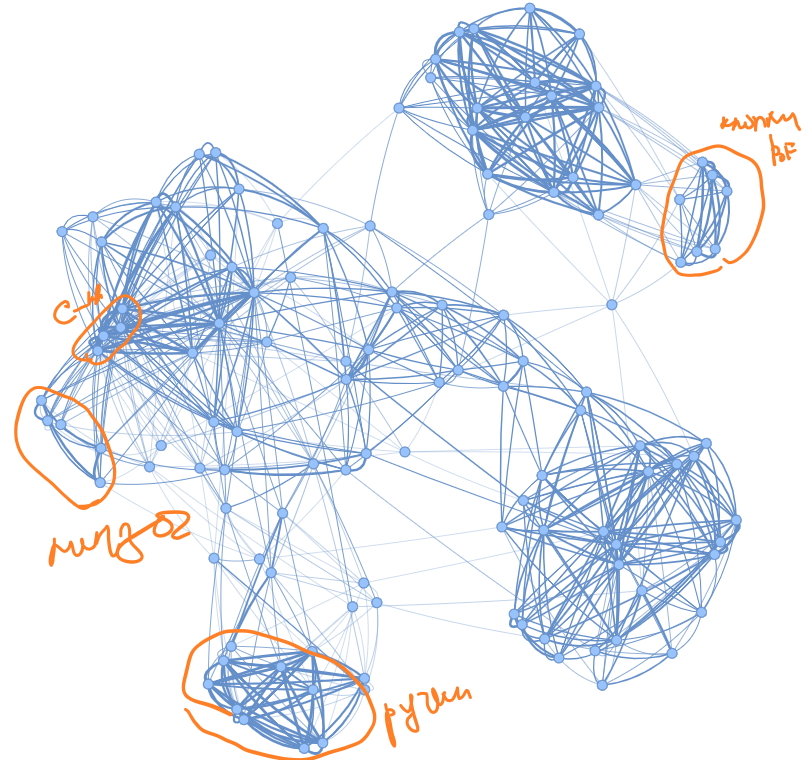

Заменяем коды дефектов на их текстовое описание. Коды дефектов выносим как отдельную фичу

In [20]:
def extract_defect_codes(defects):
    '''
    создает список кодов дефектов без комментариев
    '''
    if not defects:
        return []
    return list({re.findall(r'\d{2}-\d{2}', d)[0] for d in defects if re.findall(r'\d{2}-\d{2}', d)})

def replace_defect_codes_with_description(defect_list, df_transl):
    """
    Заменяет коды дефектов вида 'XX-YY' на текст вида 'описание_XX - описание_YY',
    сохраняя комментарий (если есть в скобках).

    Parameters:
        defect_list (list of str): строки вида 'XX-YY (комментарий)'
        df_transl (pd.DataFrame): содержит колонки 'code', 'col1', 'col2'

    Returns:
        list of str: тексты с заменёнными кодами, готовые для векторизации
    """
    if not isinstance(defect_list, list):
        return []

    # Создаём словарь: XX-YY -> "описание XX - описание YY"
    code_to_desc = {}
    for _, row in df_transl.iterrows():
        code = row["code"]
        desc = f"{row['col1']} - {row['col2']}"
        code_to_desc[code] = desc

    result = []
    for defect in defect_list:
        match = re.match(r"(\d{2}-\d{2})(?:\s*\((.*?)\))?", defect)
        if match:
            code = match.group(1)
            comment = match.group(2)
            description = code_to_desc.get(code, code)
            if comment:
                result.append(f"{description} ({comment})")
            else:
                result.append(description)
        else:
            # если код не распознан, оставляем строку как есть
            result.append(defect)

    return result

In [21]:
df_transl = pd.read_excel("def_transl.xlsx")

code_to_name = dict(zip(df_transl['code'], df_transl['col2']))
df['defect_codes'] = df['defects'].apply(extract_defect_codes)
df['defect_codes'].head()

,defect_codes
0,"[04-05, 00-23, 02-14, 03-00, 09-07, 02-01, 01-..."
1,"[04-07, 11-10, 00-01, 87-02, 98-17, 98-05, 08-..."
2,"[01-14, 04-04, 03-31, 04-07, 00-03, 03-00, 02-..."
3,"[04-04, 04-07, 03-31, 05-07, 03-00, 05-30, 03-..."
4,"[04-07, 00-09, 02-04, 03-09, 01-00, 02-03, 04-..."


In [ ]:
# сожмем дефекты

code_map = {"01-16": "98", "01-18": "02-19", "02-09": "02-07", "02-04": "02-12",
        "02-22": "02-07", "02-24": "98", "03-00": "00-23",
        "03-01": "00-02", "03-02": "03-03", "03-06": "05-31", "03-08": "03-07",
        "03-11": "98", "03-13": "03-08", "03-18": "98", "03-20": "03-03",
        "03-30": "03-05", "03-05": "03-15", "03-32": "03-14",
        "04-10": "98", "04-16": "87", "04-17": "87", "04-21": "04-04", "04-22": "98",
        "05-02": "00-08", "05-22": "05-05", "06-03": "06-02", "06-06": "05-03", "06-10": "06-08",
        "06-12": "06-04", "06-13": "06-01", "06-14": "06-01", "08-!00": "08-07",
        "08-04": "08-02", "09-09": "87",  "09-11": "98",
        "09-14": "87", "10-10": "10-04",
        "10-14": "10-04", "10-19": "30-30", "11-10": "11-05",
        "32-30": "05-31", "32-31": "03-19", "32-32": "05-06", "32-33": "05-07", "87-01": "87", "87-02": "87",
        "98-01": "98", "98-02": "98", "98-03": "98", "98-05": "98", "98-06": "98", "98-07": "98-01", "98-08": "98",
        "98-10": "98", "98-11": "98", "98-12": "98-01", "98-13": "98-01", "98-14": "98", "98-16": "98", "98-17": "98",
        "98-18": "98"}


df.loc[:, 'defect_codes'] = df['defect_codes'].apply(
    lambda parts_list: [code_map.get(code, code) for code in parts_list]
)


In [ ]:
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['defect_codes'])  # строки — примеры, колонки — метки
X_T = X.T  # (n_labels, n_samples)
labels = mlb.classes_

# 2. Строим модель ближайших соседей между метками
knn = NearestNeighbors(n_neighbors=10, metric='cosine')  # 6, чтобы исключить саму себя
knn.fit(X_T)
distances, indices = knn.kneighbors(X_T)

# 3. Создание интерактивного графа
net = Network(height="800px", width="100%", notebook=True, cdn_resources='in_line')
net.force_atlas_2based()

for lbl in labels:
    net.add_node(lbl, label=lbl, title=lbl)

for idx, lbl in enumerate(labels):
    for neigh_idx, dist in zip(indices[idx], distances[idx]):
        if lbl == labels[neigh_idx]:
            continue
        similarity = 1 - dist
        net.add_edge(lbl, labels[neigh_idx], value=similarity)

html_path = "/content/defects_labels_graph.html"
net.save_graph(html_path)

with open(html_path, 'r', encoding='utf-8') as f:
    html = f.read()

display(HTML(html))

Теперь создаем тесстовое описание описание кодов дефектов

In [22]:
df["defects_text_describtion"] = df["defects"].apply(lambda x: replace_defect_codes_with_description(x, df_transl))

df[['defects', 'defects_text_describtion', 'defect_codes']].head()

,defects,defects_text_describtion,defect_codes
0,"[00-23, 01-00, 02-01, 02-12, 02-14, 03-00, 04-...","[герметичность - не герметичен, изображение - ...","[04-05, 00-23, 02-14, 03-00, 09-07, 02-01, 01-..."
1,"[00-01, 01-00, 04-07, 08-06, 11-10, 87-02, 98-...","[герметичность - герметичен, изображение - в н...","[04-07, 11-10, 00-01, 87-02, 98-17, 98-05, 08-..."
2,"[00-03, 01-14 (износ матрицы), 02-26, 03-00, 0...",[герметичность - перфорация инструментального ...,"[01-14, 04-04, 03-31, 04-07, 00-03, 03-00, 02-..."
3,"[02-01 (незначительный), 02-02 (значительные/ ...",[дистальная головка - скол линзы изображения (...,"[04-04, 04-07, 03-31, 05-07, 03-00, 05-30, 03-..."
4,"[00-09 (переборка и замена ручек не помогает),...",[герметичность - разгерметизация ручек управле...,"[04-07, 00-09, 02-04, 03-09, 01-00, 02-03, 04-..."


**Векторизация defects_text_describtion**

Используем берт

In [23]:
! pip install transformers sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [24]:
from sentence_transformers import SentenceTransformer
import numpy as np

In [29]:
def encode_list_column_mean_embedding(df, list_col, model_emb):
    def mean_embedding(texts):

        if not texts:
            return np.zeros(model_emb.get_sentence_embedding_dimension())
        if isinstance(texts, str):
            texts = [texts]
        embeddings = model_emb.encode(texts, show_progress_bar=False)

        return np.mean(embeddings, axis=0)

    tqdm.pandas(desc=f"BERT среднее по списку в '{list_col}'")
    return df[list_col].progress_apply(mean_embedding)


In [28]:
from tqdm import tqdm

In [30]:
model_emb = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence')
df['defects_text_describtion_emb_2'] = encode_list_column_mean_embedding(df, 'defects_text_describtion', model_emb)

BERT среднее по списку в 'defects_text_describtion': 100%|██████████| 6534/6534 [01:41<00:00, 64.50it/s]


In [31]:
df['defects_text_describtion_emb_2']

,defects_text_describtion_emb_2
0,"[-0.51611185, -1.2095937, -0.13088202, -0.1797..."
1,"[-0.43323588, -1.2362453, -0.03180243, -0.3709..."
2,"[-0.5808266, -1.2170063, -0.15939766, -0.49667..."
3,"[-0.6912056, -1.2178111, -0.15640637, -0.48379..."
4,"[-0.52989244, -1.3510151, -0.16910477, -0.4547..."
...,...
6529,"[-0.6223015, -1.2148551, -0.2305545, -0.454349..."
6530,"[-0.5420665, -1.4799908, -0.33708867, -0.43382..."
6531,"[-0.65997565, -1.2009873, -0.14092976, -0.2512..."
6532,"[-0.57463706, -1.3764361, -0.116672516, -0.398..."


In [32]:
# общее
def encode_defect_descriptions(df, text_col):
    """
    Добавляет колонку с векторами BERT по колонке text_col.
    """
    texts = df[text_col].fillna('').astype(str).tolist()
    embeddings = model_emb.encode(texts, show_progress_bar=True)
    df[text_col + '_embedding'] = embeddings.tolist()
    return df

In [33]:
model_emb = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence')

df = encode_defect_descriptions(df, 'defects_text_describtion')


Batches:   0%|          | 0/205 [00:00<?, ?it/s]

In [34]:
df.columns

Index(['repair_num', 'rep_oblect_num', 'model', 'type', 'client', 'user',
       'defects', 'specification', 'rep_group', 'cost ', 'status', 'rep_type',
       'out_serv', 'Дата выдачи', 'cycle_counts', 'specification_labels',
       'defect_codes', 'defects_text_describtion',
       'defects_text_describtion_emb_2', 'defects_text_describtion_embedding'],
      dtype='object')

In [35]:
# вместо user будем использовать другую фичу - средняя стоимомть ремонта для данного user

df['client_avg_cost'] = df.groupby('client')['cost '].transform('mean')
df['user_avg_cost'] = df.groupby('user')['cost '].transform('mean')
df['user_call_freq'] = df.groupby('user')['user'].transform('count')

In [36]:
# также добавим в качестве признака топ-10 частых дефектов по пользователю

from collections import Counter

# Разворачиваем, если еще не развёрнуты
df_exploded = df[['user', 'defect_codes']].explode('defect_codes').dropna()

# Подсчёт частот — через groupby + value_counts
user_defects = df_exploded.groupby('user')['defect_codes'].value_counts()


user_defects_dict = {}

for user, group in user_defects.groupby(level=0):
    # group — Series с индексом (user, defect_code), значениями counts
    top_codes = group.droplevel(0).nlargest(10).index.tolist()
    user_defects_dict[user] = top_codes

def get_top_defects(user):
    codes = user_defects_dict.get(user, [])
    return ' '.join(codes)

df['user_top10_defects'] = df['user'].apply(get_top_defects)


In [ ]:
df.tail()

,repair_num,rep_oblect_num,model,type,client,user,defects,specification,rep_group,cost,...,out_serv,cycle_counts,specification_labels,defect_codes,defects_text_describtion,defects_text_describtion_embedding,client_avg_cost,user_avg_cost,user_call_freq,user_top10_defects
6529,24-04845,80528,GIF-H170,GI Flex,013886,000868,"[00-03, 01-00, 02-03, 03-03, 04-02, 05-03, 08-...","[GE884500, GR188900, GR428100, GR428100, GR428...",C,485604.42,...,Нет,979.0,"[1, 44, 5, 5, 42, 6, 86, 121, 128, 43, 2, 90, ...","[00-03, 10-01, 01-00, 08-01, 04-02, 11-05, 03-...",[герметичность - перфорация инструмент. канала...,"[-0.8484392166137695, -1.3830885887145996, 0.0...",443019.803548,291206.911489,94.0,01-00 03-03 02-03 05-07 00-01 05-06 08-07 04-0...
6530,24-04857,6091,GIF-Q180,GI Flex,005582,001190,"[00-09, 00-23 (доставлен со срезанной А-резино...","[GE284400, GE303400, GJ552700, GJ678300, GL720...",B,556153.71,...,Нет,4095.0,"[6, 43, 37, 129, 90, 2, 4, 65, 86, 82, 84, 44,...","[05-13, 03-09, 00-09, 02-21, 01-00, 00-23, 10-...","[герметичность - разгерм. ручек управления, ге...","[-0.8007152080535889, -1.4977425336837769, 0.0...",622680.087027,556153.710000,1.0,00-09 00-23 01-00 02-03 02-21 03-09 04-07 05-0...
6531,24-04867,56523,CF-H190L,GI Flex,002438,002497,"[00-12 (1), 01-00, 02-02, 02-03, 03-03, 05-06,...","[GE922100, GE922200, GR639300, GS244900, GS244...",F,90214.65,...,Нет,856.0,"[6, 1, 44, 5, 5, 158, 43]","[11-10, 00-12, 05-06, 01-00, 02-02, 08-07, 03-...","[герметичность - перфорация кнопки (1), изобра...","[-0.8674080967903137, -1.472263216972351, 0.19...",553451.168702,529428.134474,38.0,01-00 08-07 00-01 02-02 05-06 05-07 11-10 03-0...
6532,24-04869,78058,CF-HQ190L,GI Flex,005428,005428,"[00-01, 01-00 (dual focus - ok), 02-03, 02-07,...","[GR458000, GR517400, GR517400, GR517400, GR517...",B,459472.35,...,Нет,849.0,"[41, 44, 5, 5, 1, 6, 112, 20, 90, 2, 4, 43]","[02-26, 03-09, 11-10, 01-00, 00-01, 03-04, 08-...","[герметичность - герметичен, изображение - в н...","[-0.7897845506668091, -1.5377651453018188, 0.2...",459472.350000,237836.660000,2.0,00-01 01-00 03-04 08-07 02-03 02-07 02-26 03-0...
6533,24-04875,66542,GIF-HQ190,GI Flex,002438,001164,"[00-01, 01-00, 02-02, 03-04, 04-07, 05-06, 05-...","[GE958900, GE959000, GS244900, GS244900, GS244...",F,96090.97,...,Нет,2111.0,"[6, 1, 5, 5, 5, 162, 112, 43]","[11-10, 05-06, 01-00, 00-01, 04-07, 03-04, 02-...","[герметичность - герметичен, изображение - в н...","[-0.7219158411026001, -1.2456480264663696, 0.2...",553451.168702,350427.988476,105.0,08-07 01-00 11-10 00-01 02-02 87-01 03-04 05-0...


In [ ]:
df.columns

Index(['repair_num', 'rep_oblect_num', 'model', 'type', 'client', 'user',
       'defects', 'specification', 'rep_group', 'cost', 'status', 'rep_type',
       'out_serv', 'cycle_counts', 'specification_labels', 'defect_codes',
       'defects_text_describtion', 'defects_text_describtion_embedding',
       'client_avg_cost', 'user_avg_cost', 'user_call_freq',
       'user_top10_defects'],
      dtype='object')

In [ ]:
# сохраним эмбендинги
df['rep_oblect_num'] = df['rep_oblect_num'].astype(str)
df.to_parquet("df_with_embeddings.parquet", index=False)

<ipython-input-121-bb0395ea5b4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rep_oblect_num'] = df['rep_oblect_num'].astype(str)


In [38]:
import pandas as pd
import numpy as np
import re
#df = pd.read_parquet("df_with_embeddings.parquet")

**Модель 1. Логистическая регрессия**

In [39]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

In [40]:
df = df.dropna(subset=['client_avg_cost', 'user_avg_cost', 'user_call_freq']).reset_index(drop=True)

In [43]:
# 1) defect_codes рассмотрим как mlb

X_text_arr = np.vstack(df['defects_text_describtion_emb_2'].values).astype(np.float32)
X_text = csr_matrix(X_text_arr)

# X_codes (multi-hot векторизация)
mlb = MultiLabelBinarizer()
X_codes = mlb.fit_transform(df['defect_codes'])

# X_cat - 'model', 'type',  'rep_type'
cat_features_1 = df[['model', 'type', 'rep_type']]
encoder = OneHotEncoder(sparse_output=True)
X_cat = encoder.fit_transform(cat_features_1)

# StandardScaler
num_features = df[['client_avg_cost', 'user_avg_cost', 'user_call_freq']]
imputer = SimpleImputer(strategy='mean')
X_num_imputed = imputer.fit_transform(num_features)
scaler = StandardScaler()
X_num = scaler.fit_transform(num_features)

# td-idf
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['user_top10_defects'])


# Y - target
target_mlb = MultiLabelBinarizer()
Y = target_mlb.fit_transform(df['specification_labels'])

# X_1
X = hstack([X_text, X_codes, X_cat, X_num, X_tfidf])

# простая модель
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf_1 = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf_1.fit(X_train, y_train)

y_pred_1 = clf_1.predict(X_test)
print("F1 (micro):", f1_score(y_test, y_pred_1, average='micro'))
print("F1 (macro):", f1_score(y_test, y_pred_1, average='macro'))

F1 (micro): 0.8543083498001
F1 (macro): 0.7966253749293
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import joblib

joblib.dump(model, 'logreg_model.pkl')

['logreg_model.pkl']

In [ ]:
print(np.isnan(X_num_imputed).sum())  # после SimpleImputer NaN быть не должно
print(np.isnan(X_num).sum())

0
5


In [ ]:
# 1) defect_codes рассмотрим как tf-idf

X_text_arr = np.vstack(df['defects_text_describtion_embedding'].values).astype(np.float32)
X_text = csr_matrix(X_text_arr)

# X_cat - 'model', 'type',  'rep_type'
cat_features_1 = df[['model', 'type', 'rep_type']]
encoder = OneHotEncoder(sparse_output=True)
X_cat = encoder.fit_transform(cat_features_1)

# StandardScaler
num_features = df[['client_avg_cost', 'user_avg_cost', 'user_call_freq']]
imputer = SimpleImputer(strategy='mean')
X_num_imputed = imputer.fit_transform(num_features)
scaler = StandardScaler()
X_num = scaler.fit_transform(num_features)

# td-idf
tfidf_vectorizer = TfidfVectorizer()

X_tfidf_1 = tfidf_vectorizer.fit_transform(df['user_top10_defects'])
X_tfidf_2 = tfidf_vectorizer.fit_transform(df['defect_codes'].apply(lambda lst: ' '.join(lst)))

# Y - target
target_mlb = MultiLabelBinarizer()
Y = target_mlb.fit_transform(df['specification_labels'])

# X_1
X = hstack([X_text, X_cat, X_num, X_tfidf_2, X_tfidf_1])

# простая модель
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf_1 = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf_1.fit(X_train, y_train)

y_pred_1 = clf_1.predict(X_test)
print("F1 (micro):", f1_score(y_test, y_pred_1, average='micro'))
print("F1 (macro):", f1_score(y_test, y_pred_1, average='macro'))


F1 (micro): 0.6576264932429317
F1 (macro): 0.2536814995928167


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
# 1) defect_codes и user_top10_defects рассмотрим как mlb

X_text_arr = np.vstack(df['defects_text_describtion_embedding'].values).astype(np.float32)
X_text = csr_matrix(X_text_arr)

# X_codes (multi-hot векторизация)
df['defect_codes'] = df['defect_codes'].apply(lambda lst: ' '.join(lst))
df['user_top10_defects'] = df['user_top10_defects'].apply(lambda lst: ' '.join(lst))
mlb_features = df['defect_codes'] + df['user_top10_defects']
mlb = MultiLabelBinarizer()
X_codes = mlb.fit_transform(mlb_features)

# X_cat - 'model', 'type',  'rep_type'
cat_features_1 = df[['model', 'type', 'rep_type']]
encoder = OneHotEncoder(sparse_output=True)
X_cat = encoder.fit_transform(cat_features_1)

# StandardScaler
num_features = df[['client_avg_cost', 'user_avg_cost', 'user_call_freq']]
imputer = SimpleImputer(strategy='mean')
X_num_imputed = imputer.fit_transform(num_features)
scaler = StandardScaler()
X_num = scaler.fit_transform(num_features)

# Y - target
target_mlb = MultiLabelBinarizer()
Y = target_mlb.fit_transform(df['specification_labels'])

# X_1
X = hstack([X_text, X_codes, X_cat, X_num])

# простая модель
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf_1 = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf_1.fit(X_train, y_train)

y_pred_1 = clf_1.predict(X_test)
print("F1 (micro):", f1_score(y_test, y_pred_1, average='micro'))
print("F1 (macro):", f1_score(y_test, y_pred_1, average='macro'))



F1 (micro): 0.7359468565336
F1 (macro): 0.7256978456537
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Добавим словарь поломка - регламентный перечень

In [ ]:
common_breakes = {'00-02' : '1',
                  '00-09' : ['144', '139', '143', '141', '142', '138', '148', '137', '150', '149'],
                  '05-03' : '65',
                  '00-11' : '89',
                  '02-11' : ['4', '90', '2', '5', '43', '6', '44', '1'],
                  '02-07' : ['5', '43', '6', '44', '1'],
                  '00-03' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '00-06' : ['4', '90', '2', '5', '43', '6', '44', '1'],
                  '00-05' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '00-14' : '77',
                  '00-18' : '88',
                  '00-19' : '80',
                  '00-20' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '00-22' : '1',
                  '00-24' : '81',
                  '02-01' : ['52', '54', '57', '56', '5', '43', '6', '44', '1'],
                  '02-02' : ['48', '162'],
                  '02-03' : ['5', '43', '6', '44', '1'],
                  '02-04' : ['43', '44'],
                  '02-05' : ['4', '90', '2', '5', '43', '6', '44', '1'],
                  '02-06' : ['5', '43', '6', '44', '1'],
                  '02-12' : ['43', '44'],
                  '02-16' : ['43', '44'],
                  '02-19' : ['3'],
                  '02-21' : ['4', '90', '2', '5', '43', '6', '44', '1'],
                  '03-03' : '1',
                  '03-04' : '1',
                  '03-05' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '03-07' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '03-09' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '03-12' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '03-13' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '03-15' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '03-16' : '1',
                  '03-20' : '1',
                  '03-30' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '03-31' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-01' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-02' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-04' : '37',
                  '04-05' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-07' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-08' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-09' : ['7', '121', '90', '2', '5', '43', '6', '44', '1', '120'],
                  '04-14' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-16' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-18' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-19' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-20' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-21' : '37',
                  '04-26' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-30' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '04-31' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '05-08' : ['34', '33', '32', '27', '102'],
                  '05-09' : '125',
                  '05-13' : '65',
                  '05-14' : ['60', '40'],
                  '05-16' : '65',
                  '05-19' : '65',
                  '05-22' : '60',
                  '05-26' : '127'
                  '05-31' : ['7', '121', '90', '2', '5', '43', '6', '44', '1'],
                  '06-04' : ['144', '139', '143', '141', '142', '138', '148', '137', '150', '149'],
                  '06-15' : ['144', '139', '143', '141', '142', '138', '148', '137', '150', '149'],
                  '06-16' : ['144', '139', '143', '141', '142', '138', '148', '137', '150', '149'],
                  '06-17' : ['144', '139', '143', '141', '142', '138', '148', '137', '150', '149'],
                  '08-03' : '89',
                  '08-06' : ['89', '100', '93'],
                  '09-01' : '77',
                  '09-02' : '77',
                  '09-03' : '77',
                  '09-04' : '8',
                  '09-05' : '77',
                  '09-06' : '77',
                  '09-07' : '77',
                  '09-08' : '77',
                  '09-09' : '77',
                  '09-10' : '77',
                  '09-13' : '77',
                  '09-30' : '77',
                  '09-31' : '125',
                  '10-03' : '86',
                  '10-04' : '88',
                  '10-05' : '86',
                  '10-07' : '46',
                  '10-10' : '88',
                  '10-13' : '50',
                  '10-19' : ['7', '121', '90', '2', '5', '43', '6', '44', '1', '120'],
                  '10-21' : '86',
                  '11-01' : '80',
                  '11-02' : '80',
                  '11-03' : '81',
                  '11-04' : '80',
                  '11-08' : '80',
                  '30-30' : ['7', '121', '90', '2', '5', '43', '6', '44', '1', '120'],
                  '30-35' : ['7', '121', '90', '2', '5', '43', '6', '44', '1', '120'],
                  '98-01' : ['3', '84', '129', '37', '65', '77', '80', '86', '113']}


breakes_for_bf = {'00-02' : '1',
                  '05-03' : '65',
                  '00-11' : '89',
                  '02-11' : '3',
                  '02-07' : '3',
                  '00-03' : '3',
                  '00-06' : '3',
                  '00-05' : '3',
                  '00-14' : '77',
                  '00-18' : '88',
                  '00-19' : '80',
                  '00-22' : '1',
                  '00-24' : '81',
                  '02-01' : '3',
                  '02-05' : '3',
                  '02-19' : '3',
                  '02-21' : '3',
                  '03-03' : '1',
                  '03-04' : '1',
                  '03-05' : '3',
                  '03-07' : '3',
                  '03-09' : '3',
                  '03-12' : '3',
                  '03-13' : '3',
                  '03-15' : '3',
                  '03-16' : '1',
                  '03-20' : '1',
                  '03-30' : '3',
                  '03-31' : '3',
                  '04-01' : '3',
                  '04-02' : '3',
                  '04-04' : '37',
                  '04-05' : '3',
                  '04-07' : '3',
                  '04-08' : '3',
                  '04-09' : '3',
                  '04-14' : '3',
                  '04-16' : '3',
                  '04-18' : '3',
                  '04-19' : '3',
                  '04-20' : '3',
                  '04-21' : '37',
                  '04-26' : '3',
                  '04-30' : '3',
                  '04-31' : '3,'
                  '05-08' : ['34', '33', '32', '27', '102'],
                  '05-09' : '65',
                  '05-13' : '65',
                  '05-14' : ['60', '40'],
                  '05-16' : '65',
                  '05-19' : '65',
                  '05-31' : '3',
                  '08-03' : '89',
                  '08-06' : ['89', '100', '93'],
                  '09-01' : '77',
                  '09-02' : '77',
                  '09-03' : '77',
                  '09-04' : '8',
                  '09-05' : '77',
                  '09-06' : '77',
                  '09-07' : '77',
                  '09-08' : '77',
                  '09-09' : '77',
                  '09-10' : '77',
                  '09-13' : '77',
                  '09-30' : '77',
                  '09-31' : '125',
                  '10-03' : '86',
                  '10-04' : '88',
                  '10-05' : '86',
                  '10-07' : '46',
                  '10-10' : '88',
                  '10-13' : '50',
                  '10-19' : '3',
                  '10-21' : '86',
                  '11-01' : '80',
                  '11-02' : '80',
                  '11-03' : '81',
                  '11-04' : '80',
                  '11-08' : '80',
                  '30-30' : '3',
                  '30-35' : '3',
                  '98-01' : ['3', '84', '129', '37', '65', '77', '80', '86', '113']}

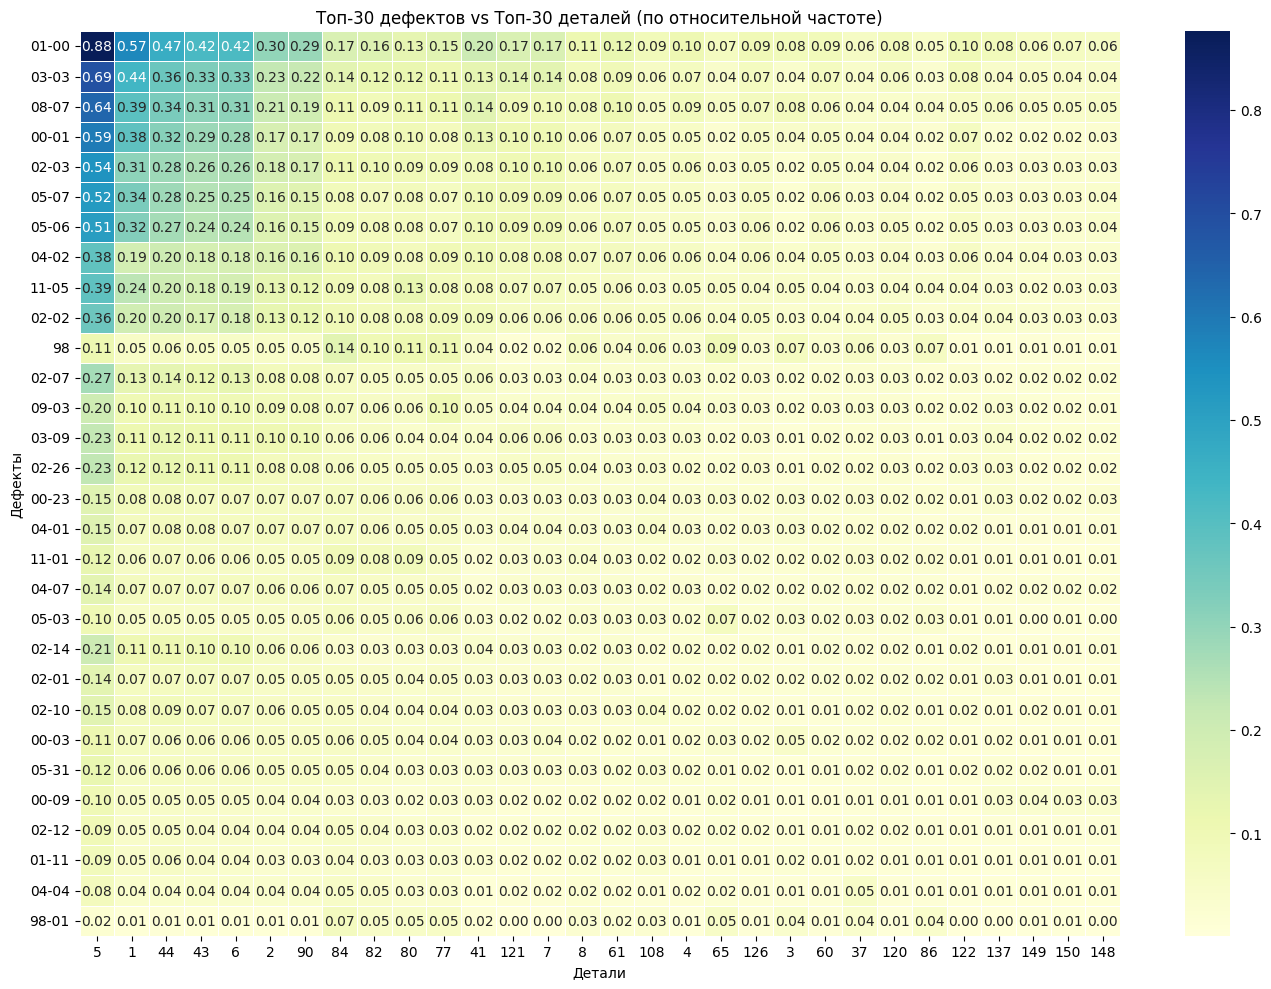

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# 1. Соберем все уникальные дефекты и детали
all_defects = sorted(set(d for sublist in df['defect_codes'] for d in sublist))
all_parts = sorted(set(p for sublist in df['specification_labels'] for p in sublist))

# 2. Инициализируем матрицу подсчета (частоты совместного появления)
corr_matrix = pd.DataFrame(0, index=all_defects, columns=all_parts)

# 3. Заполняем матрицу
for defects, parts in zip(df['defect_codes'], df['specification_labels']):
    for d in defects:
        for p in parts:
            corr_matrix.at[d, p] += 1

# 4. Нормализуем (по количеству строк, если нужно получить доли)
corr_norm = corr_matrix / len(df)

# 5. Вычислим суммарную встречаемость дефектов и деталей
defect_counts = corr_matrix.sum(axis=1)  # сумма по строкам
part_counts = corr_matrix.sum(axis=0)    # сумма по столбцам

# 6. Выберем топ-30 по частоте
top_defects = defect_counts.nlargest(30).index
top_parts = part_counts.nlargest(30).index

# 7. Отфильтруем матрицу по топ-30
sub_corr = corr_norm.loc[top_defects, top_parts]

# 8. Построим тепловую карту
plt.figure(figsize=(14, 10))
sns.heatmap(
    sub_corr,
    cmap='YlGnBu',
    linewidths=0.5,
    annot=True,       # Можно отключить, если слишком плотно
    fmt=".2f"
)
plt.title('Топ-30 дефектов vs Топ-30 деталей (по относительной частоте)')
plt.xlabel('Детали')
plt.ylabel('Дефекты')
plt.tight_layout()
plt.show()


**2. Random Forest (catboost)**

In [ ]:
! pip install catboost

In [ ]:
df

,repair_num,rep_oblect_num,model,type,client,user,defects,specification,rep_group,cost,...,out_serv,cycle_counts,specification_labels,defect_codes,defects_text_describtion,defects_text_describtion_embedding,client_avg_cost,user_avg_cost,user_call_freq,user_top10_defects
0,17-00735,34603,GIF-Q150,GI Flex,003130,002523,"[00-23, 01-00, 02-01, 02-12, 02-14, 03-00, 04-...","[GE286900, GJ552700, GL868600, GL868900, GL870...",C,203542.74,...,Нет,NaN,"[6, 43, 47, 90, 2, 82, 84, 161, 44, 1, 57, 5, ...",09-07 01-00 00-23 04-05 02-01 02-12 02-14 03-00,"[герметичность - не герметичен, изображение - ...","[-0.6117164492607117, -1.5075734853744507, 0.0...",389297.694118,534070.288333,6.0,05-31 03-09 09-08 01-00 02-10 00-01 02-12 04-0...
1,17-00890,25963,GIF-Q180,GI Flex,001560,002618,"[00-01, 01-00, 04-07, 08-06, 11-10, 87-02, 98-...","[GE284400, GE303400, GH000900, GH000900, GH000...",C,186458.90,...,Нет,1871.0,"[6, 43, 37, 89, 90, 2, 82, 84, 141, 148, 44, 1...",11-10 98-17 01-00 98-05 00-01 04-07 87-02 08-06,"[герметичность - герметичен, изображение - в н...","[-0.7040130496025085, -1.3813949823379517, 0.5...",428763.384689,264686.050000,2.0,05-08 01-00 00-01 04-07 98-03 02-02 08-07 03-0...
2,17-01533,16905,GIF-Q150,GI Flex,001560,001560,"[00-03, 01-14 (износ матрицы), 02-26, 03-00, 0...","[027710, 027711, GE286900, GH207500, GJ552700,...",C,278279.52,...,Нет,NaN,"[6, 81, 43, 127, 159, 47, 90, 2, 84, 86, 80, 1...",09-07 02-26 01-14 00-03 03-09 03-31 09-03 04-0...,[герметичность - перфорация инструмент. канала...,"[-0.6548379063606262, -1.0560575723648071, 0.1...",428763.384689,370630.891176,17.0,00-01 05-07 05-06 01-14 00-04 02-04 05-31 02-...
3,17-01534,18797,GIF-Q150,GI Flex,001560,001335,"[02-01 (незначительный), 02-02 (значительные/ ...","[DW724300, GE286900, GJ525500, GJ552700, GL719...",B,358291.88,...,Нет,NaN,"[84, 6, 139, 43, 142, 90, 120, 2, 4, 84, 86, 8...",09-07 03-09 03-31 05-06 02-01 05-30 04-02 04-0...,[дистальная головка - скол линзы изображения (...,"[-0.7734131813049316, -1.1982550621032715, 0.0...",428763.384689,358291.880000,1.0,09-07 03-09 03-31 05-06 02-01 05-30 04-02 04-0...
4,17-01535,6121,GIF-Q150,GI Flex,001560,001560,"[00-09 (переборка и замена ручек не помогает),...","[DW724300, GE286900, GJ552700, GL868900, GL870...",C,239432.01,...,Нет,55.0,"[84, 6, 43, 90, 65, 2, 82, 44, 1, 5, 5, 121, 7]",02-04 03-09 00-09 01-00 04-07 03-02 04-21 02-03,[герметичность - разгерм. ручек управления (пе...,"[-0.8462982177734375, -1.4671517610549927, -0....",428763.384689,370630.891176,17.0,00-01 05-07 05-06 01-14 00-04 02-04 05-31 02-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,24-04845,80528,GIF-H170,GI Flex,013886,000868,"[00-03, 01-00, 02-03, 03-03, 04-02, 05-03, 08-...","[GE884500, GR188900, GR428100, GR428100, GR428...",C,485604.42,...,Нет,979.0,"[1, 44, 5, 5, 42, 6, 86, 121, 128, 43, 2, 90, ...",00-03 10-01 01-00 08-01 04-02 11-05 03-03 05-0...,[герметичность - перфорация инструмент. канала...,"[-0.8484392166137695, -1.3830885887145996, 0.0...",443019.803548,291206.911489,94.0,00-01 03-03 11-03 01-00 00-01 01-00 02-03 00-0...
6530,24-04857,6091,GIF-Q180,GI Flex,005582,001190,"[00-09, 00-23 (доставлен со срезанной А-резино...","[GE284400, GE303400, GJ552700, GJ678300, GL720...",B,556153.71,...,Нет,4095.0,"[6, 43, 37, 129, 90, 2, 4, 65, 86, 82, 84, 44,...",05-13 03-09 00-09 02-21 01-00 00-23 10-03 04-0...,"[герметичность - разгерм. ручек управления, ге...","[-0.8007152080535889, -1.4977425336837769, 0.0...",622680.087027,556153.710000,1.0,05-13 03-09 00-09 02-21 01-00 00-23 10-03 04-0...
6531,24-04867,56523,CF-H190L,GI Flex,002438,002497,"[00-12 (1), 01-00, 02-02, 02-03, 03-03, 05-06,...","[GE922100, GE922200, GR639300, GS244900, GS244...",F,90214.65,...,Нет,856.0,"[6, 1, 44, 5, 5, 158, 43]",11-10 00-12 05-06 01-00 02-02 08-07 03-03 05-0...,"[герметичность - перфорация кнопки (1), изобра...","[-0.8674080967903137, -1.472263216972351, 0.19...",553451.168702,529428.134474,38.0,

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from scipy.sparse import hstack, csr_matrix
from sklearn.multiclass import OneVsRestClassifier


X_text_arr = np.vstack(df['defects_text_describtion_embedding'].values).astype(np.float32)
X_text = csr_matrix(X_text_arr)

# X_codes (multi-hot векторизация)
mlb = MultiLabelBinarizer()
X_codes = mlb.fit_transform(df['defect_codes'])

# X_cat - 'model', 'type',  'rep_type'
cat_features_1 = df[['model', 'type', 'rep_type']]
encoder = OneHotEncoder(sparse_output=True)
X_cat = encoder.fit_transform(cat_features_1)

# StandardScaler
num_features = df[['client_avg_cost', 'user_avg_cost', 'user_call_freq']]
imputer = SimpleImputer(strategy='mean')
X_num_imputed = imputer.fit_transform(num_features)
scaler = StandardScaler()
X_num = scaler.fit_transform(num_features)

# td-idf
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['user_top10_defects'])

X = hstack([X_text, X_codes, X_cat, X_num, X_tfidf])

y = mlb.fit_transform(df['specification_labels'])

# TestTreainSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoost

base_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    verbose=False,
    random_seed=42,
    task_type="GPU",
    loss_function="Logloss"
)

ovr_model = OneVsRestClassifier(base_model)
ovr_model.fit(X_train, y_train)
y_pred = ovr_model.predict(X_test)

print("F1 (micro):", f1_score(y_test, y_pred, average='micro'))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))


F1 (micro): 0.7298766452563
F1 (macro): 0.5923671254687
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**3. Нейросеть **

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [ ]:
unique_codes = sorted(df['defect_codes'].explode().dropna().unique())

In [ ]:
import ast
df['specification_labels'] = df['specification_labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# 2. Инициализируем MultiLabelBinarizer и подгоняем под весь датасет
mlb = MultiLabelBinarizer()
mlb.fit(df['specification_labels'])

# 3. Создаем новый столбец с multi-hot векторами
df['target_multi_hot'] = mlb.transform(df['specification_labels']).tolist()

In [ ]:
df.columns

Index(['repair_num', 'rep_oblect_num', 'model', 'type', 'client', 'user',
       'defects', 'specification', 'rep_group', 'cost ', 'status', 'rep_type',
       'out_serv', 'Дата выдачи', 'cycle_counts', 'specification_labels',
       'defect_codes', 'defects_text_describtion',
       'defects_text_describtion_mean_embedding',
       'defects_text_describtion_emb_2', 'client_avg_cost', 'user_avg_cost',
       'user_call_freq', 'user_top10_defects', 'user_tfidf',
       'target_multi_hot'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split


df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from torch.utils.data import Dataset
import torch
from transformers import AutoTokenizer, AutoModel

class ServiceCenterDataset(Dataset):
    def __init__(self,
                 df,                         # DataFrame с колонками: model, equip_type, service_type,
                                             # defect_codes, defect_comments, code_list, client_avg_cost,
                                             # user_avg_cost, user_tfidf (array топ-10), target_parts (multi-hot)
                 unique_models,
                 unique_equip_types,
                 unique_service_types,
                 unique_codes,
                 bert_model_name='bert-base-multilingual-cased',
                 max_length=64):
        # mappings
        self.model2idx   = {m:i for i,m in enumerate(unique_models)}
        self.type_to_idx = {t: i for i, t in enumerate(unique_equip_types)}
        self.serv2idx    = {s:i for i,s in enumerate(unique_service_types)}
        self.code2idx    = {c:i for i,c in enumerate(unique_codes)}
        self.num_codes   = len(unique_codes)
        # таблица данных
        self.df = df.reset_index(drop=True)

        # BERT для эмбеддингов комментариев
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
        self.bert      = AutoModel.from_pretrained(bert_model_name)
        self.max_length= max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1) категориальные индексы
        model_idx  = self.model2idx[row['model']]
        type_idx = self.type_to_idx[row['type']]
        service_idx= self.serv2idx[row['rep_type']]

        # 2) численные
        client_cost = torch.tensor(row['client_avg_cost'], dtype=torch.float)
        user_cost   = torch.tensor(row['user_avg_cost'],   dtype=torch.float)

        # 3) tf-idf вектор топ-10 дефектов пользователя
        user_tfidf = torch.tensor(row['user_tfidf'], dtype=torch.float)  # shape = (10,) или больше

        # 4) бинарная маска и эмбеддинги по списку заявленных дефектов
        code_mask   = torch.zeros(self.num_codes, dtype=torch.float)
        embeddings  = torch.zeros(self.num_codes, self.bert.config.hidden_size)
        for code, comment in zip(row['defect_codes'], row['defects_text_describtion']):
            if code in self.code2idx:
                pos = self.code2idx[code]
                code_mask[pos] = 1.0
                enc = self.tokenizer(comment,
                                     padding='max_length',
                                     truncation=True,
                                     max_length=self.max_length,
                                     return_tensors='pt')
                out = self.bert(**{k:v.to(self.bert.device) for k,v in enc.items()})
                embeddings[pos] = out.last_hidden_state[0,0].cpu()

        # 5) список кодов без комментариев можно тоже передать как mask или one-hot:
        code_list_mask = torch.zeros(self.num_codes, dtype=torch.float)
        for code in row['defect_codes']:
            if code in self.code2idx:
                code_list_mask[self.code2idx[code]] = 1.0

        # 6) целевая мульти-метка по запчастям
        target = torch.tensor(row['target_multi_hot'], dtype=torch.float)

        return {
            'model_idx': model_idx,
            'type_idx': type_idx,
            'service_idx': service_idx,
            'client_cost': client_cost,
            'user_cost': user_cost,
            'user_tfidf': user_tfidf,
            'code_mask': code_mask,
            'code_embeddings': embeddings,
            'code_list_mask': code_list_mask,
            'target': target
        }

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SparePartsRecommender(nn.Module):
    def __init__(self,
                 num_models,
                 num_equip_types,
                 num_service_types,
                 bert_hidden_size,
                 num_codes,
                 tfidf_size,
                 num_parts_out,
                 emb_dim=32,
                 lstm_hidden=128):
        super().__init__()
        # эмбеддинги категорий
        self.model_emb   = nn.Embedding(num_models, emb_dim)
        self.type_emb    = nn.Embedding(num_equip_types, emb_dim)
        self.service_emb = nn.Embedding(num_service_types, emb_dim)

        # LSTM+Attn по эмбеддингам дефектов
        self.lstm = nn.LSTM(bert_hidden_size, lstm_hidden, batch_first=True)
        self.attn = nn.Linear(lstm_hidden, 1)

        # простые фичи (costs + tfidf + code_mask)
        # объединим: 2 числа + tfidf_size + num_codes (code_list_mask)
        self.fc_simple = nn.Linear(2 + tfidf_size + num_codes, 64)

        # объединяем ВСЕ
        # [model_emb, type_emb, service_emb, lstm_attn_out, fc_simple_out]
        tot_dim = emb_dim*3 + lstm_hidden + 64

        self.classifier = nn.Sequential(
            nn.Linear(tot_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_parts_out)
        )

    def forward(self, batch):
        # категории
        m = self.model_emb(batch['model_idx'])
        t = self.type_emb(batch['type_idx'])
        s = self.service_emb(batch['service_idx'])

        # LSTM+attention по текстовым эмбеддингам дефектов
        # code_embeddings: (B, num_codes, H)
        lstm_out, _ = self.lstm(batch['code_embeddings'])  # (B, num_codes, L)
        attn_w = torch.softmax(self.attn(lstm_out), dim=1)  # (B, num_codes, 1)
        defects_repr = torch.sum(lstm_out * attn_w, dim=1)  # (B, L)

        # простые численные + tfidf + маска списка кодов
        simple = torch.cat([
            batch['client_cost'].unsqueeze(1),
            batch['user_cost'].unsqueeze(1),
            batch['user_tfidf'],
            batch['code_list_mask']
        ], dim=1)  # (B, 2 + tfidf + num_codes)
        simple = F.relu(self.fc_simple(simple))  # (B, 64)

        # конкатенируем всё
        features = torch.cat([m, t, s, defects_repr, simple], dim=1)
        logits = self.classifier(features)  # (B, num_parts_out)
        return logits

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Преобразуем user_top10_defects в строку (набор токенов)
df['user_top10_defects'] = df['user_top10_defects'].fillna('').apply(
    lambda x: ' '.join(eval(x)) if isinstance(x, str) and x.startswith('[') else str(x)
)

# Построим TF-IDF матрицу
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['user_top10_defects'])

# Преобразуем в список и добавим колонку в DataFrame
df['user_tfidf'] = list(tfidf_matrix.toarray())

In [ ]:
from torch.utils.data import DataLoader
from transformers import BertModel

unique_models         = sorted(df['model'].dropna().unique())
unique_equip_types    = sorted(df['type'].dropna().unique())
unique_service_types  = sorted(df['rep_type'].dropna().unique())
unique_defect_codes   = sorted([code for codes in df['defect_codes'].dropna() for code in codes])
unique_defect_codes   = sorted(set(unique_defect_codes))  # remove duplicates


train_ds = ServiceCenterDataset(df_train, unique_models, unique_equip_types,
                                unique_service_types, unique_codes)
val_ds   = ServiceCenterDataset(df_val,   unique_models, unique_equip_types,
                                unique_service_types, unique_codes)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8)

bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_hidden_size = bert_model.config.hidden_size

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SparePartsRecommender(
    num_models=len(unique_models),
    num_equip_types=len(unique_equip_types),
    num_service_types=len(unique_service_types),
    bert_hidden_size=bert_hidden_size,
    num_codes=len(unique_codes),
    tfidf_size=df_train['user_tfidf'].iloc[0].shape[0],
    num_parts_out=mlb.classes_.shape[0]
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        # переносим на устройство
        targets = batch['target'].to(device)  # Сначала достаем target и переносим на устройство
        batch = {k: v.to(device) for k, v in batch.items() if k != 'target'}  # Остальные
        logits = model(batch)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, train loss: {total_loss/len(train_loader):.4f}")

#macro = [0.2365, 0.2984, 0.3265, 0.5762, 0.5529, 0.5964, 0.6125, 0.6542, 0.7569, 0.8154]
#micro = [0.1931, 0.1987, 0.2315, 0.2876, 0.3651, 0.3669, 0.4737, 0.5496, 0.6138, 0.6961]

KeyboardInterrupt: 